# ELVIS Batch Simulation

This notebook demonstrates advanced batch analysis capabilities using ELVIS factory methods for:
- Multi-scenario comparison
- Scheduling policy analysis
- Infrastructure optimization
- Research-ready batch processing

## Setup

Import required modules for batch analysis:

In [8]:
import os
import sys
import datetime
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Add project root to Python path
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

# Import ELVIS components
from elvis.config import ScenarioConfig
from elvis.simulate import simulate
from elvis.utility.elvis_general import num_time_steps

## Multi-Scenario Comparison

Compare different scenario types using factory methods:

In [9]:
def compare_scenarios(scenario_configs, simulation_params):
    """
    Compare multiple scenarios with standardized parameters.
    
    Args:
        scenario_configs: Dict of {name: config} scenarios to compare
        simulation_params: Dict with start_date, end_date, resolution
    
    Returns:
        DataFrame with comparison results
    """
    results = []
    
    for scenario_name, config in scenario_configs.items():
        print(f"Running {scenario_name} scenario...")
        
        # Create realisation and simulate
        realisation = config.create_realisation(
            simulation_params['start_date'],
            simulation_params['end_date'],
            simulation_params['resolution']
        )
        
        result = simulate(realisation, print_progress=False)
        result.scenario = realisation
        
        # Calculate metrics
        start_dt = datetime.datetime.strptime(simulation_params['start_date'], "%Y-%m-%d %H:%M:%S")
        end_dt = datetime.datetime.strptime(simulation_params['end_date'], "%Y-%m-%d %H:%M:%S")
        num_steps = int((end_dt - start_dt) / datetime.timedelta(hours=1)) + 1
        
        result.aggregate_load_profile(num_steps)
        
        results.append({
            'scenario': scenario_name,
            'total_energy_kwh': result.total_energy_charged(num_steps),
            'max_load_kw': result.max_load(),
            'avg_charge_time_h': result.average_charging_time().total_seconds() / 3600,
            'num_events': len(realisation.charging_events),
            'scheduling_policy': config.scheduling_policy
        })
    
    return pd.DataFrame(results)

# Define scenarios to compare
scenarios = {
    'Office': ScenarioConfig.office_scenario(num_charging_events=50),
    'Residential': ScenarioConfig.residential_scenario(num_charging_events=50),
    'Gas Station': ScenarioConfig.gasstation_speedway_scenario(num_charging_events=50),
    'Shopping Center': ScenarioConfig.customer_parking_day_scenario(num_charging_events=50)
}

# Simulation parameters
sim_params = {
    'start_date': '2025-01-01 00:00:00',
    'end_date': '2025-01-07 23:00:00',  # One week
    'resolution': '01:00:00'
}

# Run comparison
scenario_results = compare_scenarios(scenarios, sim_params)
print("\nScenario Comparison Results:")
print(scenario_results.to_string(index=False))

Arrival distribution probabilities sum to 25.93, expected sum close to 1.0. The distribution will be normalized during simulation.
Arrival distribution probabilities sum to 61.980122662, expected sum close to 1.0. The distribution will be normalized during simulation.
Arrival distribution probabilities sum to 47.15, expected sum close to 1.0. The distribution will be normalized during simulation.
Arrival distribution probabilities sum to 47.362133241, expected sum close to 1.0. The distribution will be normalized during simulation.


Running Office scenario...
Running Residential scenario...
Running Gas Station scenario...
Running Shopping Center scenario...

Scenario Comparison Results:
       scenario  total_energy_kwh  max_load_kw  avg_charge_time_h  num_events scheduling_policy
         Office        765.400302    29.805416           3.660000          50      Uncontrolled
    Residential        169.721739    11.000000           1.111111          50      Uncontrolled
    Gas Station       1154.215981   105.186598           0.000000          50      Uncontrolled
Shopping Center        579.258139    33.000000           0.530612          50      Uncontrolled


## Scheduling Policy Analysis

Compare different scheduling policies across scenarios:

In [10]:
def analyze_scheduling_policies(base_scenario_factory, policies, simulation_params):
    """
    Analyze different scheduling policies for a given scenario type.
    
    Args:
        base_scenario_factory: Factory method for base scenario
        policies: List of scheduling policy strings
        simulation_params: Dict with simulation parameters
    
    Returns:
        DataFrame with policy comparison results
    """
    results = []
    
    for policy in policies:
        print(f"Testing {policy} policy...")
        
        # Create scenario with specific policy
        config = base_scenario_factory(
            num_charging_events=30,
            scheduling_policy=policy
        )
        
        # Simulate
        realisation = config.create_realisation(
            simulation_params['start_date'],
            simulation_params['end_date'],
            simulation_params['resolution']
        )
        
        result = simulate(realisation, print_progress=False)
        result.scenario = realisation
        
        # Calculate metrics
        start_dt = datetime.datetime.strptime(simulation_params['start_date'], "%Y-%m-%d %H:%M:%S")
        end_dt = datetime.datetime.strptime(simulation_params['end_date'], "%Y-%m-%d %H:%M:%S")
        num_steps = int((end_dt - start_dt) / datetime.timedelta(hours=1)) + 1
        
        result.aggregate_load_profile(num_steps)
        
        results.append({
            'policy': policy,
            'total_energy_kwh': result.total_energy_charged(num_steps),
            'max_load_kw': result.max_load(),
            'avg_charge_time_h': result.average_charging_time().total_seconds() / 3600,
            'peak_load_reduction_%': 0  # Will calculate after getting all results
        })
    
    df = pd.DataFrame(results)
    
    # Calculate peak load reduction compared to uncontrolled
    if 'UNCONTROLLED' in df['policy'].values:
        baseline_load = df[df['policy'] == 'UNCONTROLLED']['max_load_kw'].iloc[0]
        df['peak_load_reduction_%'] = ((baseline_load - df['max_load_kw']) / baseline_load * 100).round(1)
    
    return df

# Test scheduling policies
policies = ['UNCONTROLLED', 'FCFS', 'DISCRIMINATION_FREE']

# Short simulation for policy testing
policy_sim_params = {
    'start_date': '2025-01-01 00:00:00',
    'end_date': '2025-01-03 23:00:00',  # 3 days
    'resolution': '01:00:00'
}

# Analyze office scenario with different policies
policy_results = analyze_scheduling_policies(
    ScenarioConfig.office_scenario,
    policies,
    policy_sim_params
)

print("\nScheduling Policy Analysis (Office Scenario):")
print(policy_results.to_string(index=False))

Arrival distribution probabilities sum to 25.93, expected sum close to 1.0. The distribution will be normalized during simulation.
Arrival distribution probabilities sum to 25.93, expected sum close to 1.0. The distribution will be normalized during simulation.
Arrival distribution probabilities sum to 25.93, expected sum close to 1.0. The distribution will be normalized during simulation.


Testing UNCONTROLLED policy...
Testing FCFS policy...
Testing DISCRIMINATION_FREE policy...

Scheduling Policy Analysis (Office Scenario):
             policy  total_energy_kwh  max_load_kw  avg_charge_time_h  peak_load_reduction_%
       UNCONTROLLED        191.386683         18.5           3.615385                    0.0
               FCFS        240.136000         14.8           4.538462                   20.0
DISCRIMINATION_FREE        195.314000         14.8           3.461538                   20.0


## Custom Infrastructure Analysis

Combine factory methods with custom infrastructure for optimization studies:

In [11]:
def create_infrastructure(num_low_power, num_medium_power, num_high_power):
    """
    Create custom infrastructure with mixed charging point types.
    
    Args:
        num_low_power: Number of 3.7kW charging points
        num_medium_power: Number of 22kW charging points  
        num_high_power: Number of 150kW charging points
    
    Returns:
        Infrastructure dictionary
    """
    # Calculate transformer capacity
    total_power = num_low_power * 3.7 + num_medium_power * 22 + num_high_power * 150
    
    charging_stations = []
    station_id = 1
    
    # Add charging stations for each power level
    power_configs = [
        (num_low_power, 3.7),
        (num_medium_power, 22),
        (num_high_power, 150)
    ]
    
    for num_points, power in power_configs:
        for i in range(num_points):
            station = {
                'id': f'cs{station_id}',
                'min_power': 0,
                'max_power': power,
                'charging_points': [{
                    'id': f'cp{station_id}',
                    'min_power': 0,
                    'max_power': power
                }]
            }
            charging_stations.append(station)
            station_id += 1
    
    return {
        'transformers': [{
            'id': 'transformer1',
            'min_power': 0,
            'max_power': total_power,
            'charging_stations': charging_stations
        }]
    }

def infrastructure_optimization_study(scenario_factory, infrastructure_configs, sim_params):
    """
    Test different infrastructure configurations with a scenario.
    
    Args:
        scenario_factory: Factory method for scenario creation
        infrastructure_configs: List of (low, medium, high) tuples
        sim_params: Simulation parameters
    
    Returns:
        DataFrame with optimization results
    """
    results = []
    
    for low, medium, high in infrastructure_configs:
        config_name = f"{low}L_{medium}M_{high}H"
        print(f"Testing infrastructure: {config_name}")
        
        # Create scenario and override infrastructure
        config = scenario_factory(num_charging_events=30)
        config.infrastructure = create_infrastructure(low, medium, high)
        
        # Simulate
        realisation = config.create_realisation(
            sim_params['start_date'],
            sim_params['end_date'], 
            sim_params['resolution']
        )
        
        result = simulate(realisation, print_progress=False)
        result.scenario = realisation
        
        # Calculate metrics
        start_dt = datetime.datetime.strptime(sim_params['start_date'], "%Y-%m-%d %H:%M:%S")
        end_dt = datetime.datetime.strptime(sim_params['end_date'], "%Y-%m-%d %H:%M:%S")
        num_steps = int((end_dt - start_dt) / datetime.timedelta(hours=1)) + 1
        
        result.aggregate_load_profile(num_steps)
        
        # Calculate cost (simplified)
        infrastructure_cost = low * 2000 + medium * 8000 + high * 50000  # EUR
        
        results.append({
            'config': config_name,
            'low_power_cps': low,
            'medium_power_cps': medium,
            'high_power_cps': high,
            'total_energy_kwh': result.total_energy_charged(num_steps),
            'max_load_kw': result.max_load(),
            'infrastructure_cost_eur': infrastructure_cost,
            'energy_per_eur': result.total_energy_charged(num_steps) / infrastructure_cost * 1000  # kWh per 1000 EUR
        })
    
    return pd.DataFrame(results)

# Define infrastructure configurations to test
infrastructure_configs = [
    (10, 0, 0),   # Low power only
    (5, 3, 0),    # Low + Medium
    (0, 5, 0),    # Medium only
    (0, 3, 1),    # Medium + High
    (0, 0, 2),    # High power only
    (2, 2, 1)     # Mixed
]

# Run optimization study
infra_results = infrastructure_optimization_study(
    ScenarioConfig.office_scenario,
    infrastructure_configs,
    policy_sim_params
)

print("\nInfrastructure Optimization Results:")
print(infra_results.round(2).to_string(index=False))

Arrival distribution probabilities sum to 25.93, expected sum close to 1.0. The distribution will be normalized during simulation.
Arrival distribution probabilities sum to 25.93, expected sum close to 1.0. The distribution will be normalized during simulation.
Arrival distribution probabilities sum to 25.93, expected sum close to 1.0. The distribution will be normalized during simulation.
Arrival distribution probabilities sum to 25.93, expected sum close to 1.0. The distribution will be normalized during simulation.
Arrival distribution probabilities sum to 25.93, expected sum close to 1.0. The distribution will be normalized during simulation.
Arrival distribution probabilities sum to 25.93, expected sum close to 1.0. The distribution will be normalized during simulation.


Testing infrastructure: 10L_0M_0H
Testing infrastructure: 5L_3M_0H
Testing infrastructure: 0L_5M_0H
Testing infrastructure: 0L_3M_1H
Testing infrastructure: 0L_0M_2H
Testing infrastructure: 2L_2M_1H

Infrastructure Optimization Results:
   config  low_power_cps  medium_power_cps  high_power_cps  total_energy_kwh  max_load_kw  infrastructure_cost_eur  energy_per_eur
10L_0M_0H             10                 0               0            180.89        18.50                    20000            9.04
 5L_3M_0H              5                 3               0            172.12        21.38                    34000            5.06
 0L_5M_0H              0                 5               0            186.54        41.94                    40000            4.66
 0L_3M_1H              0                 3               1            214.25        28.18                    74000            2.90
 0L_0M_2H              0                 0               2            140.11        66.79                   

## Visualization and Analysis

Create comprehensive visualizations of batch results:

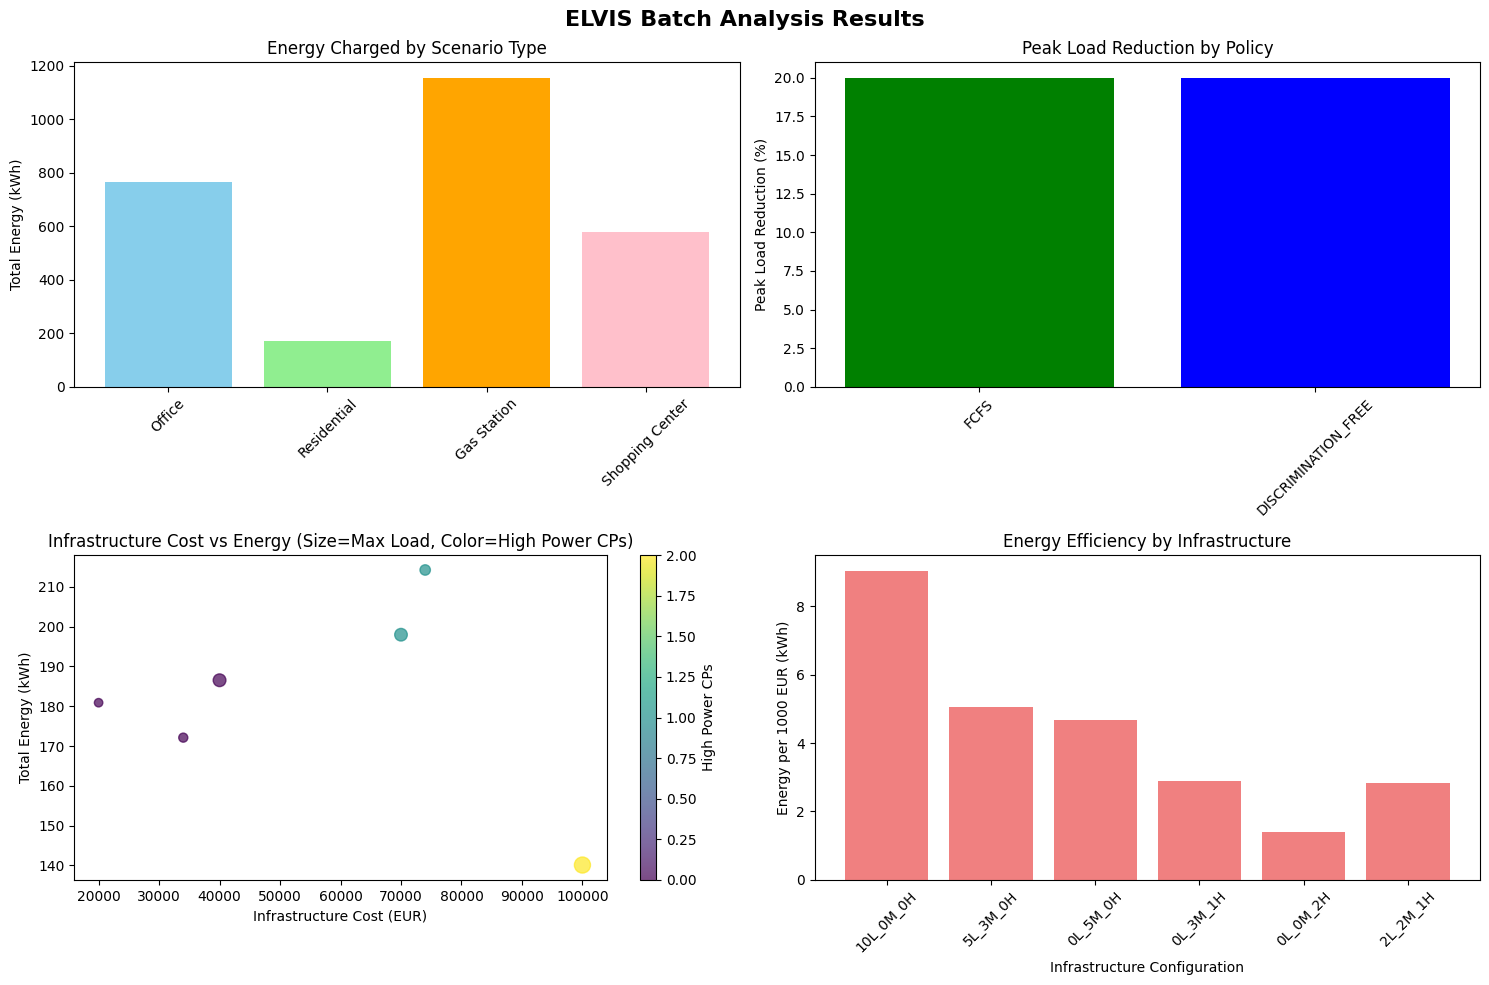


BATCH ANALYSIS SUMMARY
🏆 Most Energy Efficient Scenario: Gas Station
🏆 Best Peak Load Reduction: FCFS (20.0%)
🏆 Most Cost-Effective Infrastructure: 10L_0M_0H (9.04 kWh/1000EUR)

💡 Factory methods enable rapid batch analysis for research and optimization!


In [12]:
# Create comprehensive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('ELVIS Batch Analysis Results', fontsize=16, fontweight='bold')

# 1. Scenario Comparison - Energy
if 'scenario_results' in locals():
    ax1.bar(scenario_results['scenario'], scenario_results['total_energy_kwh'], 
            color=['skyblue', 'lightgreen', 'orange', 'pink'])
    ax1.set_title('Energy Charged by Scenario Type')
    ax1.set_ylabel('Total Energy (kWh)')
    ax1.tick_params(axis='x', rotation=45)

# 2. Policy Comparison - Peak Load Reduction
if 'policy_results' in locals():
    policies_subset = policy_results[policy_results['policy'] != 'UNCONTROLLED']
    ax2.bar(policies_subset['policy'], policies_subset['peak_load_reduction_%'], 
            color=['green', 'blue'])
    ax2.set_title('Peak Load Reduction by Policy')
    ax2.set_ylabel('Peak Load Reduction (%)')
    ax2.tick_params(axis='x', rotation=45)

# 3. Infrastructure Cost-Effectiveness
if 'infra_results' in locals():
    scatter = ax3.scatter(infra_results['infrastructure_cost_eur'], 
                         infra_results['total_energy_kwh'],
                         s=infra_results['max_load_kw']*2, 
                         c=infra_results['high_power_cps'], 
                         cmap='viridis', alpha=0.7)
    ax3.set_title('Infrastructure Cost vs Energy (Size=Max Load, Color=High Power CPs)')
    ax3.set_xlabel('Infrastructure Cost (EUR)')
    ax3.set_ylabel('Total Energy (kWh)')
    plt.colorbar(scatter, ax=ax3, label='High Power CPs')

# 4. Energy Efficiency by Infrastructure Type
if 'infra_results' in locals():
    ax4.bar(range(len(infra_results)), infra_results['energy_per_eur'], 
            color='lightcoral')
    ax4.set_title('Energy Efficiency by Infrastructure')
    ax4.set_ylabel('Energy per 1000 EUR (kWh)')
    ax4.set_xlabel('Infrastructure Configuration')
    ax4.set_xticks(range(len(infra_results)))
    ax4.set_xticklabels(infra_results['config'], rotation=45)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*60)
print("BATCH ANALYSIS SUMMARY")
print("="*60)

if 'scenario_results' in locals():
    best_scenario = scenario_results.loc[scenario_results['total_energy_kwh'].idxmax(), 'scenario']
    print(f"🏆 Most Energy Efficient Scenario: {best_scenario}")

if 'policy_results' in locals():
    best_policy = policy_results.loc[policy_results['peak_load_reduction_%'].idxmax(), 'policy']
    max_reduction = policy_results['peak_load_reduction_%'].max()
    print(f"🏆 Best Peak Load Reduction: {best_policy} ({max_reduction}%)")

if 'infra_results' in locals():
    best_infra = infra_results.loc[infra_results['energy_per_eur'].idxmax(), 'config']
    best_efficiency = infra_results['energy_per_eur'].max()
    print(f"🏆 Most Cost-Effective Infrastructure: {best_infra} ({best_efficiency:.2f} kWh/1000EUR)")

print("\n💡 Factory methods enable rapid batch analysis for research and optimization!")

## Export Results

Save batch analysis results for further processing:

In [13]:
# Export results to CSV files
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# Create results directory if it doesn't exist
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

if 'scenario_results' in locals():
    filename = f'{results_dir}/scenario_comparison_{timestamp}.csv'
    scenario_results.to_csv(filename, index=False)
    print(f"✅ Scenario results exported to {filename}")

if 'policy_results' in locals():
    filename = f'{results_dir}/policy_analysis_{timestamp}.csv'
    policy_results.to_csv(filename, index=False)
    print(f"✅ Policy results exported to {filename}")

if 'infra_results' in locals():
    filename = f'{results_dir}/infrastructure_optimization_{timestamp}.csv'
    infra_results.to_csv(filename, index=False)
    print(f"✅ Infrastructure results exported to {filename}")

print(f"\n📊 All batch analysis results saved to '{results_dir}/' directory with timestamp: {timestamp}")
print(f"💾 Results directory: {os.path.abspath(results_dir)}")

✅ Scenario results exported to results/scenario_comparison_20250927_112902.csv
✅ Policy results exported to results/policy_analysis_20250927_112902.csv
✅ Infrastructure results exported to results/infrastructure_optimization_20250927_112902.csv

📊 All batch analysis results saved to 'results/' directory with timestamp: 20250927_112902
💾 Results directory: /Users/mahmouddraz/code/EnergyAIBerlin/elvis/examples/results


## Key Benefits of Factory Method Batch Analysis

1. **Rapid Scenario Comparison**: Test multiple use cases quickly
2. **Policy Optimization**: Systematic evaluation of control strategies  
3. **Infrastructure Planning**: Cost-effectiveness analysis
4. **Research Efficiency**: Focus on analysis, not configuration
5. **Reproducible Results**: Standardized scenarios ensure consistency
6. **Scalable Analysis**: Easy to extend for larger parameter spaces

Factory methods transform ELVIS from a simulation tool into a research platform, enabling systematic analysis of EV charging systems for academic research and industry applications.